In [1]:
#!/usr/bin/env python3.4

import os
import sys
import re
import cv2
import uuid
import random
import imageio
import numpy as np
import torch
import torch_scatter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

# torch.multiprocessing.set_start_method(method='spawn', force=True)

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
sys.path.append('../')

from scipy import misc
from PIL import Image
from tqdm import tqdm
from omegaconf import OmegaConf, DictConfig
from evaluation import eval_utils as eu

/tmp/ipykernel_7133/3037835397.py:22: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc


In [17]:
# turn lines to dict
def lines_to_dict(lines):
    lines_dict = {}
    for line in lines[1:]:
        key, value = line.split(": ")
        lines_dict[key] = float(value.strip())
    return lines_dict

In [31]:
output_1st_stage_dir = "../workdir/carla/iclight_vidtome_opt_1st_hardmsk_flow"
output_2nd_vid_stage_dir = "../workdir/carla/iclight_vidtome_opt_vid_hardmsk_flow"
output_2nd_uvt_stage_dir = "../workdir/carla/iclight_vidtome_opt_hardmsk_flow"
files = sorted(os.listdir(output_1st_stage_dir))
# file = random.choice(files)
file = files[7]
config = OmegaConf.load(os.path.join(output_1st_stage_dir, file, 'config.yaml'))
print(list(config.generation.prompt.values())[0])

result_vid_file = os.path.join(output_2nd_vid_stage_dir, file, 'result.txt')
result_uvt_file = os.path.join(output_2nd_uvt_stage_dir, file, 'result.txt')
with open(result_vid_file, 'r') as f:
    lines_vid = f.readlines()
with open(result_uvt_file, 'r') as f:
    lines_uvt = f.readlines()

result_vid_dict = lines_to_dict(lines_vid)
result_uvt_dict = lines_to_dict(lines_uvt)

print("vid result: ", result_vid_dict)
print("uvt result: ", result_uvt_dict)

overall_diff = abs(result_vid_dict['clip-frame'] - result_uvt_dict['clip-frame']) + \
            abs(result_vid_dict['clip-text'] - result_uvt_dict['clip-text']) + \
            abs(result_vid_dict['pick-score'] - result_uvt_dict['pick-score']) / 10
print("Diff of {file}: ", overall_diff)

The video depicts a urban scene. The road appears to be clean and well-maintained, with clear lane markings. The sky is partly cloudy, suggesting a calm weather condition.
vid result:  {'clip-frame': 0.9385, 'clip-text': 0.3462, 'pick-score': 20.7265, 'warp-error-ssim': 93.53, 'z_fps': 0.4862, 'z_max_memory_allocated(M)': 7879.5063, 'z_resolution': 717.3284, 'z_total_frames': 105.0, 'z_total_time(s)': 215.9395}
uvt result:  {'clip-frame': 0.9364, 'clip-text': 0.3386, 'pick-score': 20.2875, 'warp-error-ssim': 95.05, 'z_fps': 0.4855, 'z_max_memory_allocated(M)': 7879.5063, 'z_resolution': 717.3284, 'z_total_frames': 105.0, 'z_total_time(s)': 216.2638}
Diff of {file}:  0.053599999999999995


In [1]:
pil_list_vid = eu.video_to_pil_list(os.path.join(output_2nd_vid_stage_dir, file, "output.mp4"))
pil_list_uvt = eu.video_to_pil_list(os.path.join(output_2nd_uvt_stage_dir, file, "output.mp4"))

idx = random.randint(0, len(pil_list_vid) - 1)
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(pil_list_vid[idx])
plt.title(f"Frame {idx} from Video Representation")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pil_list_uvt[idx])
plt.title(f"Frame {idx} from UVT Representation")
plt.axis("off")

NameError: name 'eu' is not defined

In [7]:
data_config = config.data
if data_config.scene_type.lower() == "sceneflow":
    from utils.dataparsers import SceneFlowDataParser
    data_parser = SceneFlowDataParser(data_config, config.device)
elif data_config.scene_type.lower() == "carla":
    from utils.dataparsers import CarlaDataParser
    data_config.data_dir = os.path.join('../', data_config.data_dir)
    data_parser = CarlaDataParser(data_config, config.device)
elif data_config.scene_type.lower() == "robotrix":
    from utils.dataparsers import RobotrixDataParser
    data_parser = RobotrixDataParser(data_config, config.device)
elif data_config.scene_type.lower() == "interiornet":
    from utils.dataparsers import InteriorNetDataParser
    data_parser = InteriorNetDataParser(data_config, config.device)
elif data_config.scene_type.lower() == "video":
    from utils.dataparsers import VideoDataParser
    data_parser = VideoDataParser(data_config, config.device)
else:
    raise NotImplementedError(f"Scene type {data_config.scene_type} is not supported.")

frame_ids = eu.get_frame_ids(config.generation.frame_range, config.generation.frame_ids)
frames, _, _, flows, past_flows, mask_bwds = data_parser.load_video(frame_ids=frame_ids)  

/data1/jing_li/anaconda3/envs/iclight-bkup/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-05 21:31:45.507019: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 21:31:45.520676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746451905.535363   20648 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746451905.539612   20648 cuda_b

[INFO] frame indexes:  0 1 ... 188 189


Loading Data: 100%|██████████| 190/190 [00:20<00:00,  9.16it/s]


[INFO] frame size (900, 1600) resize to (540, 960) and centercrop to (536, 960)
[INFO] frame size (900, 1600) resize to (540, 960) and centercrop to (536, 960)
[INFO] frame size (900, 1600) resize to (540, 960) and centercrop to (536, 960)
please consider installing flash attention for faster inference
MemFlowNet_skflow
no flash attention installed
[Using basicencoder as context encoder]
[Using basicencoder as feature encoder]
[Using GMA-SK2]
[Using corr_fn default]
[Loading ckpt from /data1/yang_liu/python_workspace/IC-Light/models/memflow/MemFlowNet_things.pth]
[INFO] Saving future flows to ../data/carla/sim2real_2_6/data_collect_town01_results/routes_town01_02_06_20_36_50/rgb_front/future_flow_memflow as .pt files
[INFO] Saving past flows to ../data/carla/sim2real_2_6/data_collect_town01_results/routes_town01_02_06_20_36_50/rgb_front/past_flow_memflow as .pt files
[INFO] Saving target flows to ../data/carla/sim2real_2_6/data_collect_town01_results/routes_town01_02_06_20_36_50/rgb_fr

Loading Flows:   0%|          | 0/190 [00:00<?, ?it/s]/data1/yang_liu/python_workspace/IC-Light/notebooks/../utils/dataparsers/video_dataparser.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

[INFO] frame size (448, 800) resize to (538, 960) and centercrop to (536, 960)
[INFO] frame size (448, 800) resize to (538, 960) and centercrop to (536, 960)


/data1/jing_li/anaconda3/envs/iclight-bkup/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Assigning flow ids: 100%|██████████| 189/189 [00:00<00:00, 719.37it/s]


[INFO] Scatter with Time Dimention.
Total number of unique voxels: 44261498 / 97766400


In [41]:
with torch.no_grad():
    pil_list = eu.video_to_pil_list(os.path.join(output_1st_stage_dir, file, "output.mp4"))
    edited_images = torch.concat([eu.load_image(pil, flows.device, flows.dtype) for pil in pil_list], dim=0) / 255.0
    N, _, H, W = edited_images.shape
    pil_tensor = edited_images.permute(0, 2, 3, 1).reshape(N*H*W, -1)
    voxel_coords = torch.cat([data_parser.unq_inv[:, None], torch.div(pil_tensor, 16/255, rounding_mode='floor')], dim=1)
    _, unq_inv, _ = torch.unique(voxel_coords, return_inverse=True, return_counts=True, dim=0)
    pil_tensor = torch_scatter.scatter(pil_tensor, unq_inv, dim=0, reduce='mean')
    print(f"Total number of unique voxels: {pil_tensor.shape[0]} / {N*H*W}")

    images = pil_tensor[unq_inv].reshape(N, H*W, -1) # N x HW x 3
    images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

Total number of unique voxels: 43332006 / 97766400


(-0.5, 959.5, 535.5, -0.5)

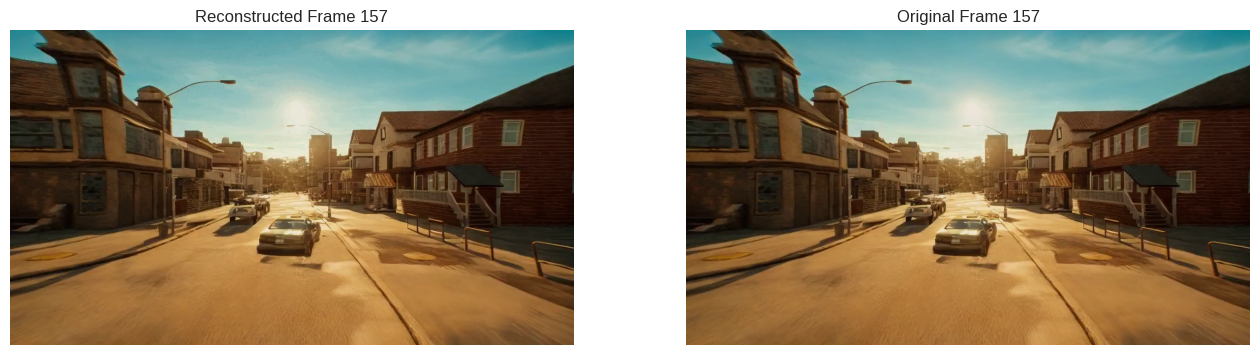

In [43]:
idx = random.randint(0, N-1)
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(images[idx].permute(1, 2, 0).cpu().numpy())
plt.title(f"Reconstructed Frame {idx}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edited_images[idx].permute(1, 2, 0).cpu().numpy())
plt.title(f"Original Frame {idx}")
plt.axis("off")

In [40]:
ssims = []
psnrs = []
lpipss = []


for i in tqdm(range(len(images))):
    psnr = eu.psnr(images[i], edited_images[i]).mean()
    ssim = eu.ssim(images[i], edited_images[i])
    lpips = eu.lpips_func(images[i], edited_images[i])

    psnrs.append(psnr)
    ssims.append(ssim)
    lpipss.append(lpips)

print("  SSIM : {:>12.7f}".format(torch.tensor(ssims).mean(), ".5"))
print("  PSNR : {:>12.7f}".format(torch.tensor(psnrs).mean(), ".5"))
print("  LPIPS: {:>12.7f}".format(torch.tensor(lpipss).mean(), ".5"))

100%|██████████| 190/190 [00:03<00:00, 55.20it/s]

  SSIM :    0.9623709
  PSNR :   39.7146263
  LPIPS:    0.1109558
